In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7791.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8401.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5761.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8451.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5511.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2721.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2921.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/371.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5671.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5421.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4061.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4751.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/1891.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7851.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blue

In [2]:
#!pip install imagecodecs

In [3]:
!pip install tensorflow tifffile opencv-python
import tifffile as tiff

In [4]:
import os
import numpy as np
import cv2
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
RGB_FOLDER = "rgb"  # ✅ Folder name for RGB images

def load_rgb_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, RGB_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        # Assuming RGB images are JPG/PNG
        files = [f for f in os.listdir(band_path) if f.lower().endswith((".jpg", ".png"))]
        print(f"\n{label.upper()} — Found {len(files)} RGB images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)

                # Load RGB image
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)

                if img is None:
                    print(f"[ERROR] Could not read {f}, skipping...")
                    continue

                # Convert BGR (OpenCV default) to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize
                img = cv2.resize(img, IMAGE_SIZE)

                # Normalize to float32
                img = img.astype(np.float32)

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} RGB images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_rgb, y_rgb = load_rgb_dataset()
print("✅ Final dataset shape:", X_rgb.shape, y_rgb.shape)  # Expecting: (num_images, 224, 224, 3), (num_images,)


NORUST — Found 819 RGB images


Loading norust: 100%|██████████| 819/819 [00:01<00:00, 556.11it/s]



RUST — Found 848 RGB images


Loading rust: 100%|██████████| 848/848 [00:01<00:00, 521.77it/s]



✅ Finished loading: 1667 RGB images total.
✅ Final dataset shape: (1667, 224, 224, 3) (1667,)


In [5]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image before NDVI computation
SELECTED_BANDS = [3, 5]  # Red, NIR

BAND_FOLDERS = {
    0: "rgb",
    1: "blueband",
    2: "greenband",
    3: "redband",
    4: "rededgeband",
    5: "nir"
}

def compute_ndvi_image(red, nir):
    # Compute NDVI = (NIR - Red) / (NIR + Red)
    ndvi = (nir - red) / (nir + red + 1e-6)
    ndvi = np.clip(ndvi, -1, 1)
    return ndvi.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

def load_ndvi_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_files = {band_id: {} for band_id in SELECTED_BANDS}

        for band_id in SELECTED_BANDS:
            band_path = os.path.join(DATA_DIR, BAND_FOLDERS[band_id], label)
            if not os.path.exists(band_path):
                raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

            for f in os.listdir(band_path):
                ext = f.lower().split('.')[-1]
                if band_id == 0 and ext not in ["jpg", "jpeg", "png"]:
                    continue
                elif band_id != 0 and ext != "tif":
                    continue

                try:
                    base = int(f.split('.')[0])
                    band_files[band_id][base] = os.path.join(band_path, f)
                except:
                    print(f"[WARN] Skipping unreadable filename: {f}")

        # Match samples across bands
        common_bases = set(k - (k % 10) for k in band_files[SELECTED_BANDS[0]].keys())
        for band_id in SELECTED_BANDS[1:]:
            common_bases &= set(k - (k % 10) for k in band_files[band_id].keys())

        print(f"\n{label.upper()} — Found {len(common_bases)} complete sample sets")

        for base in tqdm(sorted(common_bases), desc=f"Loading {label}"):
            try:
                band_images = {}
                for band_id in SELECTED_BANDS:
                    file_id = base + band_id
                    file_path = band_files[band_id].get(file_id, None)
                    if file_path is None:
                        raise FileNotFoundError(f"[MISSING] {file_id} in band {BAND_FOLDERS[band_id]}")

                    img = tiff.imread(file_path)
                    img = cv2.resize(img, IMAGE_SIZE)
                    band_images[band_id] = img.astype(np.float32)

                red = band_images[3]
                nir = band_images[5]

                ndvi_img = compute_ndvi_image(red, nir)
                X.append(ndvi_img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping sample base {base}: {e}")

    print(f"\n✅ Finished loading: {len(X)} images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_ndvi, y_ndvi = load_ndvi_dataset()  # From your NDVI loader
print("✅ Final dataset shape:", X_ndvi.shape, y_ndvi.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 complete sample sets


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 403.10it/s]



RUST — Found 848 complete sample sets


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 377.33it/s]



✅ Finished loading: 1667 images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [6]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
RED_BAND_ID = 3  # Red band
RED_BAND_FOLDER = "redband"  # Folder name for red band

def load_red_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, RED_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} red band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} red band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_red, y_red = load_red_band_dataset()  # From your red band loader
print("✅ Final dataset shape:", X_red.shape, y_red.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 red band images


Loading norust: 100%|██████████| 819/819 [00:01<00:00, 807.79it/s]



RUST — Found 848 red band images


Loading rust: 100%|██████████| 848/848 [00:00<00:00, 869.77it/s]



✅ Finished loading: 1667 red band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-09-03 08:27:26.007489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756888046.029345     723 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756888046.036008     723 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
assert len(X_rgb) == len(X_ndvi) == len(X_red) == len(y_rgb) == len(y_ndvi) == len(y_red), "Mismatch in dataset lengths"
assert np.array_equal(y_rgb, y_ndvi) and np.array_equal(y_rgb, y_red), "Label mismatch among datasets"

In [9]:
y = y_rgb

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# === Normalize inputs ===
X_rgb = X_rgb / 255.0            # RGB in [0,1]
X_ndvi = X_ndvi / 1.0          # Already normalized in [-1,1]
X_red = X_red/ 255.0        # Green band normalization

# === Convert labels to categorical ===
y_cat = to_categorical(y, num_classes=2)

# === Step 1: Split into 80% train+val, 20% test ===
Xr_temp, Xr_test, Xn_temp, Xn_test, Xg_temp, Xg_test, y_temp, y_test = train_test_split(
    X_rgb, X_ndvi, X_red, y_cat,
    test_size=0.2, random_state=42, stratify=y
)

# === Step 2: Split 80% part into 70% train, 10% val ===
# 10 / 80 = 0.125 → 12.5% of train_val becomes validation
Xr_train, Xr_val, Xn_train, Xn_val, Xg_train, Xg_val, y_train, y_val = train_test_split(
    Xr_temp, Xn_temp, Xg_temp, y_temp,
    test_size=0.125, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

In [11]:
print("🔴 RGB Band Shapes:")
print("Train:", Xr_train.shape)
print("Val:  ", Xr_val.shape)
print("Test: ", Xr_test.shape)

print("\n🌿 NDVI Shapes:")
print("Train:", Xn_train.shape)
print("Val:  ", Xn_val.shape)
print("Test: ", Xn_test.shape)

print("\n🟢 Red Band Shapes:")
print("Train:", Xg_train.shape)
print("Val:  ", Xg_val.shape)
print("Test: ", Xg_test.shape)

print("\n🏷️ Label Shapes:")
print("Train:", y_train.shape)
print("Val:  ", y_val.shape)
print("Test: ", y_test.shape)

🔴 RGB Band Shapes:
Train: (1166, 224, 224, 3)
Val:   (167, 224, 224, 3)
Test:  (334, 224, 224, 3)

🌿 NDVI Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🟢 Red Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🏷️ Label Shapes:
Train: (1166, 2)
Val:   (167, 2)
Test:  (334, 2)


In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# === Define CNN model for RGB (3-channel) ===
def build_rgb_branch(input_shape):
    input_rgb = Input(shape=input_shape)  # (224,224,3)
    x = Conv2D(32, (3, 3), activation='relu')(input_rgb)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_rgb, x

# === Define CNN model for GNDVI (1-channel) ===
def build_ndvi_branch(input_shape):
    input_ndvi = Input(shape=input_shape)  # (224,224,1)
    x = Conv2D(32, (3, 3), activation='relu')(input_ndvi)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_ndvi, x

# === Define CNN model for Green band (1-channel) ===
def build_red_branch(input_shape):
    input_red = Input(shape=input_shape)  # (224,224,1)
    x = Conv2D(16, (3, 3), activation='relu')(input_red)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_red, x

# === Build branches ===
input_rgb, rgb_branch = build_rgb_branch((224, 224, 3))
input_ndvi, ndvi_branch = build_ndvi_branch((224, 224, 1))
input_red, red_branch = build_red_branch((224, 224, 1))

# === Merge branches ===
merged = Concatenate()([rgb_branch, ndvi_branch, red_branch])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)

# === Final model ===
model = Model(inputs=[input_rgb, input_ndvi, input_red], outputs=output)

I0000 00:00:1756888050.772323     723 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756888050.772989     723 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
from tensorflow.keras.optimizers import Adam
# Set custom learning rate
lr = 0.0001  # example value

optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 109, 109,  │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 186624)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 93312)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 65,754,722 (250.83 MB)

 Trainable params: 65,754,722 (250.83 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    [Xr_train, Xn_train, Xg_train], y_train,
    validation_data=([Xr_val, Xn_val, Xg_val], y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20


I0000 00:00:1756888059.400503     778 service.cc:148] XLA service 0x7bc440006220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756888059.400546     778 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756888059.400554     778 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756888059.864069     778 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/37 ━━━━━━━━━━━━━━━━━━━━ 8:26 14s/step - accuracy: 0.5312 - loss: 0.6777

I0000 00:00:1756888068.522873     778 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 387ms/step - accuracy: 0.6206 - loss: 0.8292 - val_accuracy: 0.9042 - val_loss: 0.3406
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7637 - loss: 0.4820 - val_accuracy: 0.9162 - val_loss: 0.2827
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7859 - loss: 0.4831 - val_accuracy: 0.9281 - val_loss: 0.2558
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7769 - loss: 0.4554 - val_accuracy: 0.9281 - val_loss: 0.2447
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.8344 - loss: 0.3788 - val_accuracy: 0.9222 - val_loss: 0.2334
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8401 - loss: 0.3782 - val_accuracy: 0.9341 - val_loss: 0.2407
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8333 - loss: 0.4247 - val_accuracy: 0.9222 - val_loss: 0.2276
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8533 - loss: 0.3447 - val_accuracy: 0.9281 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step

--- Train Set Metrics ---
Accuracy : 0.9657
Precision: 0.9424
Recall   : 0.9933
F1 Score : 0.9672
ROC AUC  : 0.9964

Classification Report:
              precision    recall  f1-score   support

      norust       0.99      0.94      0.96       573
        rust       0.94      0.99      0.97       593

    accuracy                           0.97      1166
   macro avg       0.97      0.97      0.97      1166
weighted avg       0.97      0.97      0.97      1166



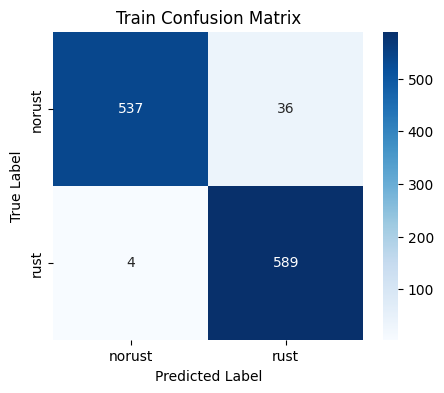

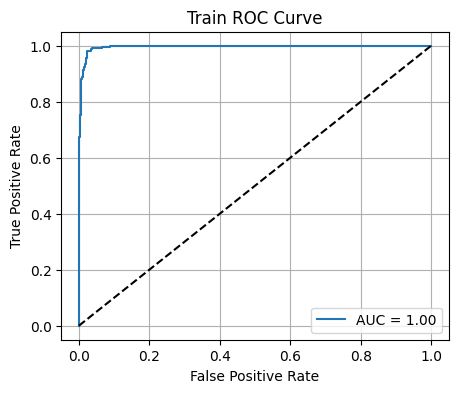

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

--- Test Set Metrics ---
Accuracy : 0.9162
Precision: 0.8859
Recall   : 0.9588
F1 Score : 0.9209
ROC AUC  : 0.9479

Classification Report:
              precision    recall  f1-score   support

      norust       0.95      0.87      0.91       164
        rust       0.89      0.96      0.92       170

    accuracy                           0.92       334
   macro avg       0.92      0.92      0.92       334
weighted avg       0.92      0.92      0.92       334



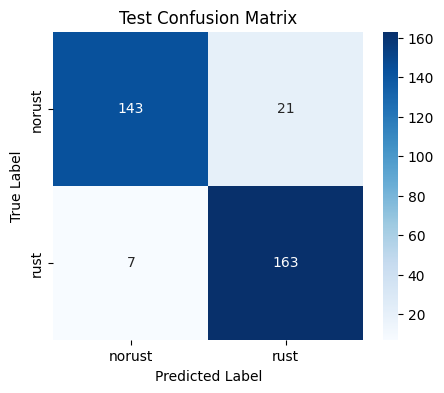

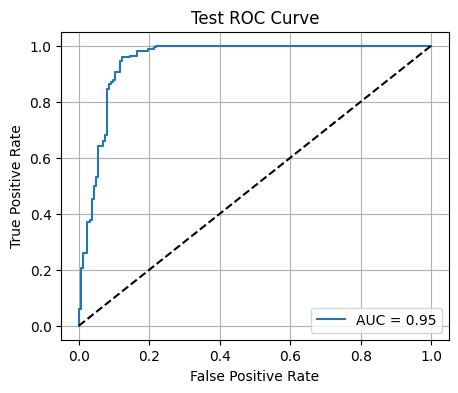

In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X_rgb, X_ndvi, X_red, y_true, set_name="Set"):
    # Predict probabilities
    y_pred_prob = model.predict([X_rgb, X_ndvi, X_red])

    # If y_true is one-hot encoded, convert to class index
    if y_true.ndim == 2 and y_true.shape[1] == 2:
        y_true = np.argmax(y_true, axis=1)

    y_pred = np.argmax(y_pred_prob, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    # Print metrics
    print(f"\n--- {set_name} Set Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["norust", "rust"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["norust", "rust"],
                yticklabels=["norust", "rust"])
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Example usage:
evaluate_model(model, Xr_train, Xn_train, Xg_train, y_train, set_name="Train")
evaluate_model(model, Xr_test, Xn_test, Xg_test, y_test, set_name="Test")